In [1]:
# Imports
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

import uproot
import particle

# Imports from this project
sys.path.insert(0, "..")
from utils import paths
from utils.input_output import load_data_from_root
from utils.histograms import find_good_binning, get_hist, calc_pull
from utils.merge_pdfs import merge_pdfs


In [2]:
# Constant variables
input_files = [paths.B2JpsiKstar_file, paths.Bs2DsPi_file]

input_file_keys = ["DecayTree", "Bs2DspiDetached/DecayTree"]


In [3]:
def load_and_merge_from_root(input_files, input_file_keys, features_to_load, N_events_max_per_dataset=np.Infinity, same_N_events_forced=True):
    if same_N_events_forced:
        N_events = []
        for i, (input_file_path, input_file_key) in enumerate(zip(input_files, input_file_keys)):
            with uproot.open(input_file_path)[input_file_key] as tree:
                N_events.append(tree.num_entries)

        N_events_per_dataset = np.min(N_events + [N_events_max_per_dataset])
    else:
        N_events_per_dataset = N_events_max_per_dataset
    
    
    # concatenate all DataFrames into one
    df = pd.DataFrame()
    # iterate over all input files
    for i, (input_file_path, input_file_key) in enumerate(tqdm(zip(input_files, input_file_keys), total=len(input_files), desc="Datasets")):
        temp_df = load_data_from_root(input_file_path, 
                                    tree_key=input_file_key,
                                    features=features_to_load, 
                                    N_entries_max=N_events_per_dataset, 
                                    batch_size=10000)
        
        temp_df.rename_axis(index={"entry":"event_id", "subentry": "track_id"},  inplace=True)

        temp_df["input_file_id"] = i

        if "B2JpsiKstar" in str(input_file_path):
            temp_df["decay_id"] = 0
        elif "Bs2DsPi" in str(input_file_path):
            temp_df["decay_id"] = 1
        else:
            raise NameError(f"Decay channel not recognized in Dataset {i}")

        # make sure all event ids are unambiguous
        if not df.empty:
            temp_df.reset_index(inplace=True)
            temp_df["event_id"] += df.index.max()[0] + 1
            temp_df.set_index(["event_id", "track_id"], inplace=True)

        # append this batch to the DataFrame
        df = pd.concat([df, temp_df])
        
    return df

# Check for the peak in Tr_p_proj on Bd SS tracks

In [4]:
features_to_load = ["B_PX", "B_PY", "B_PZ", "B_PE", 
                    "Tr_T_PX", "Tr_T_PY", "Tr_T_PZ", "Tr_T_E",
                    "B_TRUEID", "Tr_ORIG_FLAGS",
                    "Tr_MC_ID", "Tr_MC_MOTHER_ID"]

df = load_and_merge_from_root(input_files, input_file_keys, features_to_load, 1000000000)

Datasets:   0%|          | 0/2 [00:00<?, ?it/s]

Entries in the data: 215860
Entries to be loaded: 215860


Load Batches:   0%|          | 0/22 [00:00<?, ?it/s]

Entries in the data: 1199342
Entries to be loaded: 215860


Load Batches:   0%|          | 0/22 [00:00<?, ?it/s]

In [5]:
df["Tr_is_SS"] = (df["Tr_ORIG_FLAGS"] == 1).astype(int)
assert set(df["B_TRUEID"].unique()) == set([511,-511,531,-531]), "There are other signal particles than B0 and Bs"
df["B_is_strange"] = (np.abs(df["B_TRUEID"]) == 531).astype(int)

PX_proj = -1 * df[f"B_PX"] * df[f"Tr_T_PX"]
PY_proj = -1 * df[f"B_PY"] * df[f"Tr_T_PY"]
PZ_proj = -1 * df[f"B_PZ"] * df[f"Tr_T_PZ"]
PE_proj = +1 * df[f"B_PE"] * df[f"Tr_T_E"]

df["Tr_p_proj"] = np.sum([PX_proj, PY_proj, PZ_proj, PE_proj], axis=0)
df["log10_Tr_p_proj"] = np.log10(df["Tr_p_proj"])

In [6]:
df_ss = df.query("Tr_is_SS == 1")

### Tr_p_proj by Tr_MC_ID

In [7]:
x = []
y = []
uniq_mc_id, counts_mc_id = np.unique(df_ss["Tr_MC_ID"], return_counts=True)
sort_mask = np.argsort(-counts_mc_id)
uniq_mc_id = uniq_mc_id[sort_mask]
for mc_id in uniq_mc_id:
    df_mc_id = df_ss.query(f"Tr_MC_ID == {mc_id}")
    
    x.append(df_mc_id.query("B_is_strange == 0")["log10_Tr_p_proj"])
    y.append(df_mc_id.query("B_is_strange == 1")["log10_Tr_p_proj"])

In [8]:
from particle import Particle
particles = []
for mc_id in tqdm(uniq_mc_id):
    try:
        p = Particle.from_pdgid(mc_id)
        particles.append(p.name)
    except particle.ParticleNotFound as ex:
        particles.append(mc_id)

  0%|          | 0/22 [00:00<?, ?it/s]

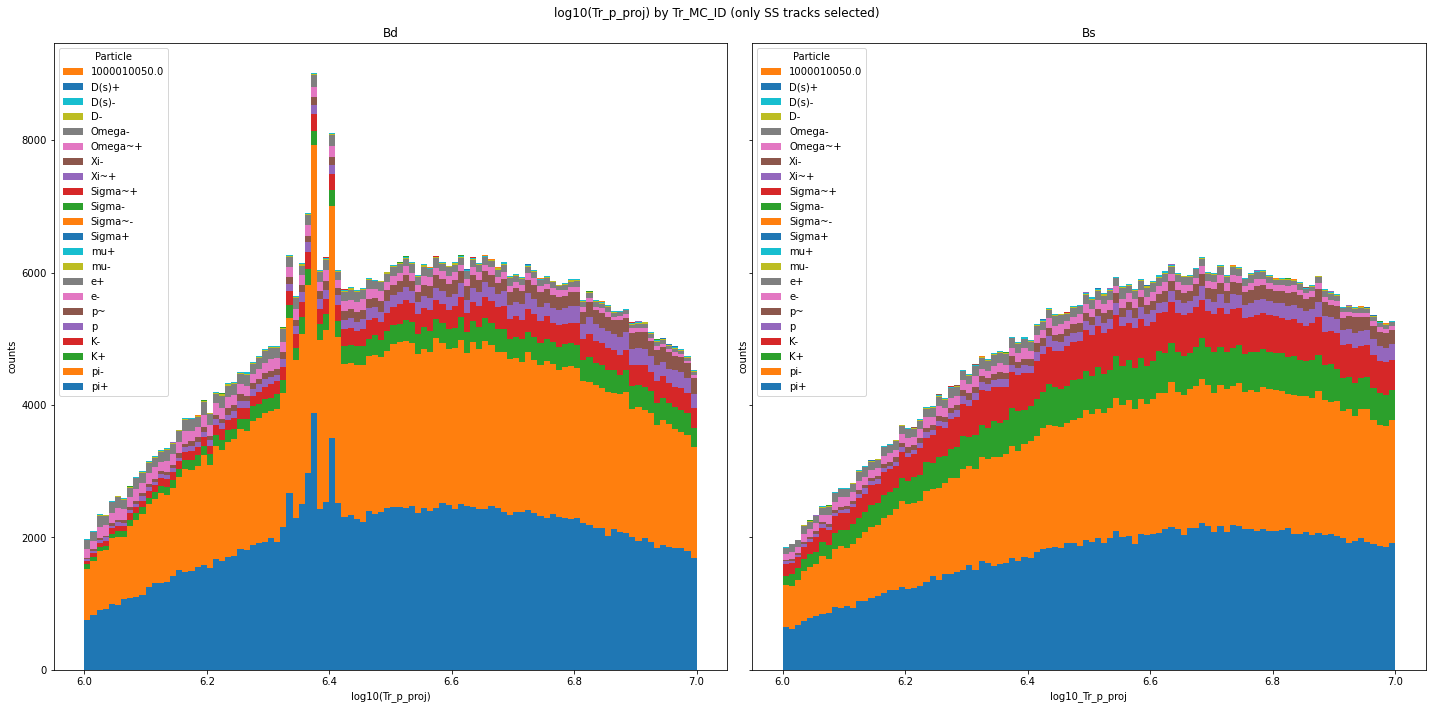

In [9]:
fig, axs = plt.subplots(1,2, figsize=(20,10), sharey=True, sharex=True)
fig.suptitle("log10(Tr_p_proj) by Tr_MC_ID (only SS tracks selected)")

axs[0].hist(x,bins=100,range=(6.0,7.0), stacked=True, label=particles)
axs[0].set_title("Bd")
axs[0].set_ylabel("counts")
axs[0].set_xlabel("log10(Tr_p_proj)")

axs[1].hist(y,bins=100,range=(6.0,7.0), stacked=True, label=particles)
axs[1].set_title("Bs")
axs[1].set_ylabel("counts")
axs[1].set_xlabel("log10_Tr_p_proj")

# reversed legend
handles, labels = axs[0].get_legend_handles_labels()
axs[0].legend(handles[::-1], labels[::-1], title='Particle', loc='upper left')

handles, labels = axs[1].get_legend_handles_labels()
axs[1].legend(handles[::-1], labels[::-1], title='Particle', loc='upper left')

plt.tight_layout()
plt.show()

### Tr_p_proj by Tr_MC_MOTHER_ID

In [10]:
x = []
y = []
uniq_mc_id, counts_mc_id = np.unique(df_ss["Tr_MC_MOTHER_ID"], return_counts=True)
sort_mask = np.argsort(-counts_mc_id)
uniq_mc_id = uniq_mc_id[sort_mask]
for mc_id in tqdm(uniq_mc_id):
    df_mc_id = df_ss.query(f"Tr_MC_MOTHER_ID == {mc_id}")
    
    x.append(df_mc_id.query("B_is_strange == 0")["log10_Tr_p_proj"])
    y.append(df_mc_id.query("B_is_strange == 1")["log10_Tr_p_proj"])

  0%|          | 0/206 [00:00<?, ?it/s]

In [11]:
from particle import Particle
particles = []
for mc_id in uniq_mc_id:
    try:
        p = Particle.from_pdgid(mc_id)
        particles.append(p.name)
    except particle.ParticleNotFound as ex:
        particles.append(mc_id)

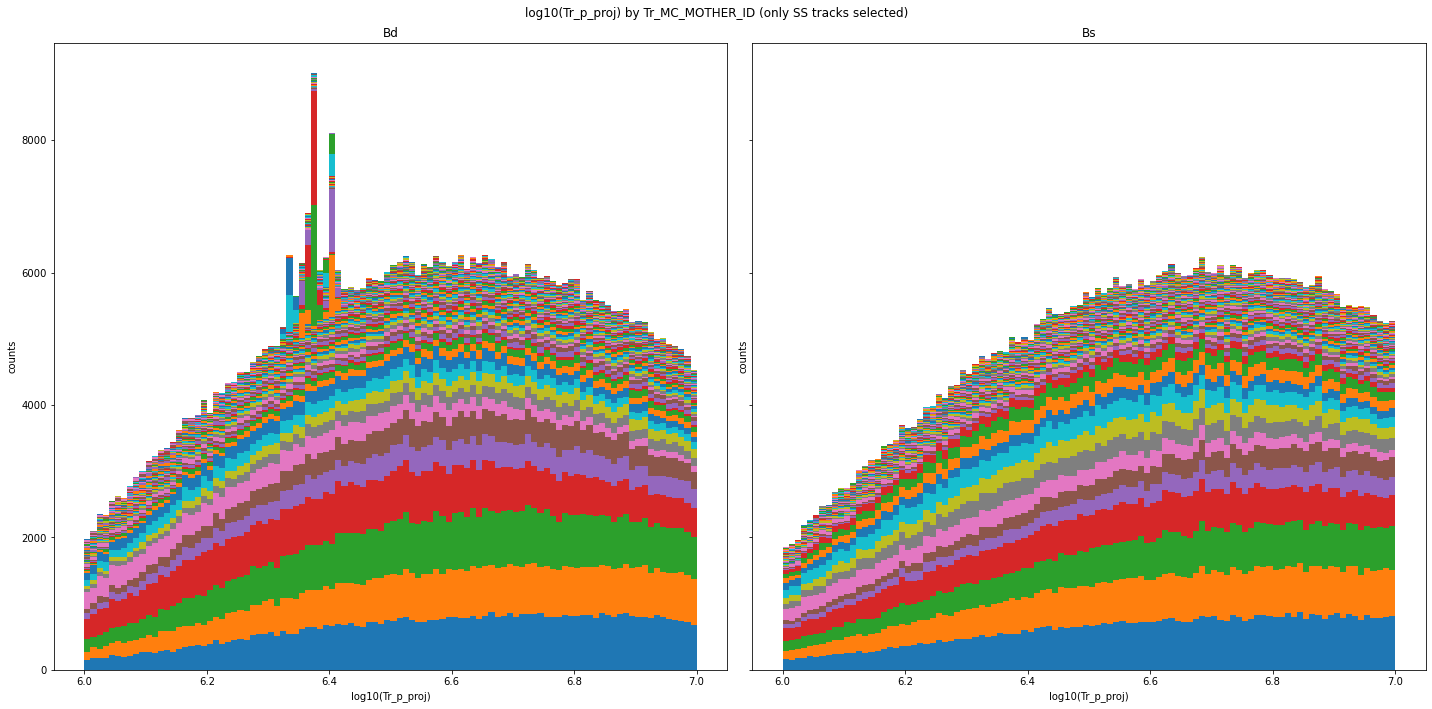

In [12]:
fig, axs = plt.subplots(1,2, figsize=(20,10), sharey=True, sharex=True)
fig.suptitle("log10(Tr_p_proj) by Tr_MC_MOTHER_ID (only SS tracks selected)")

axs[0].hist(x,bins=100,range=(6.0,7.0), stacked=True, label=particles)
axs[0].set_title("Bd")
axs[0].set_ylabel("counts")
axs[0].set_xlabel("log10(Tr_p_proj)")

axs[1].hist(y,bins=100,range=(6.0,7.0), stacked=True, label=particles)
axs[1].set_title("Bs")
axs[1].set_ylabel("counts")
axs[1].set_xlabel("log10(Tr_p_proj)")

# reversed legend
#handles, labels = axs[0].get_legend_handles_labels()
#axs[0].legend(handles[::-1], labels[::-1], title='Particle', loc='upper left')
#
#handles, labels = axs[1].get_legend_handles_labels()
#axs[1].legend(handles[::-1], labels[::-1], title='Particle', loc='upper left')

plt.tight_layout()
plt.show()

### Tr_p_proj by Tr_MC_MOTHER_ID zoomed in to see what are the resonances

In [13]:
log10p_min = 6.32
log10p_max = 6.42

temp_df = df_ss.query(f"{log10p_min} <= log10_Tr_p_proj <= {log10p_max}")

x = []
y = []
uniq_mc_id, counts_mc_id = np.unique(temp_df["Tr_MC_MOTHER_ID"], return_counts=True)
sort_mask = np.argsort(-counts_mc_id)
uniq_mc_id = uniq_mc_id[sort_mask]
for mc_id in tqdm(uniq_mc_id):
    df_mc_id = temp_df.query(f"Tr_MC_MOTHER_ID == {mc_id}")
    
    x.append(df_mc_id.query("B_is_strange == 0")["log10_Tr_p_proj"])
    y.append(df_mc_id.query("B_is_strange == 1")["log10_Tr_p_proj"])

  0%|          | 0/153 [00:00<?, ?it/s]

In [14]:
# sort by the difference in max to min bin counts
x_hists = []
x_hist_diffs = []
for xi in x:
    x_hist, bin_edges = np.histogram(xi, bins=100, range=(log10p_min,log10p_max))
    x_hists.append(x_hist)
    
    x_hist_diff = np.max(x_hist) - np.min(x_hist)
    x_hist_diffs.append(x_hist_diff)
    
x_hist_diffs = np.array(x_hist_diffs)    
sort_mask = np.argsort(-x_hist_diffs)

uniq_mc_id = uniq_mc_id[sort_mask]
x = [x[i] for i in sort_mask]
y = [y[i] for i in sort_mask]

In [15]:
from particle import Particle
particles = []
for mc_id in uniq_mc_id:
    try:
        p = Particle.from_pdgid(mc_id)
        particles.append(p.name)
    except particle.ParticleNotFound as ex:
        particles.append(mc_id)

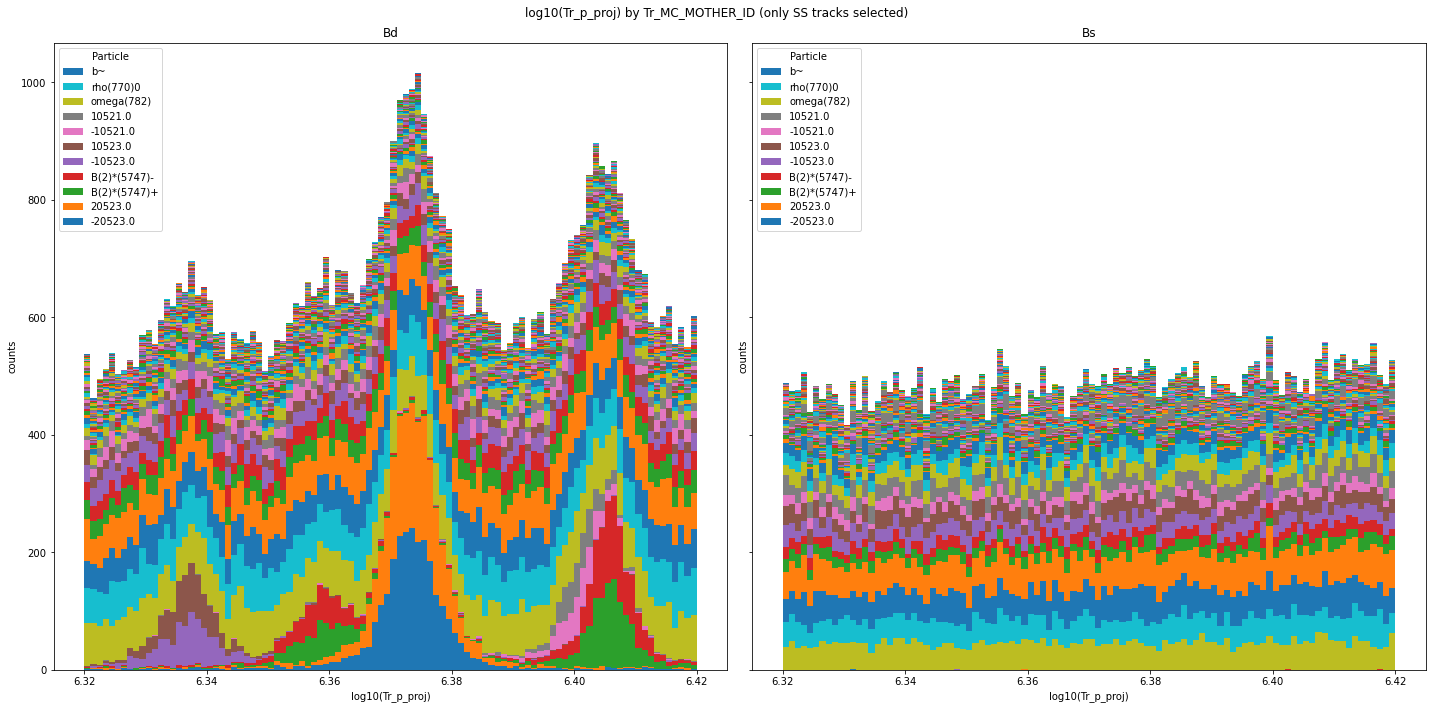

In [16]:
fig, axs = plt.subplots(1,2, figsize=(20,10), sharey=True, sharex=True)
fig.suptitle("log10(Tr_p_proj) by Tr_MC_MOTHER_ID (only SS tracks selected)")

axs[0].hist(x,bins=100,range=(log10p_min,log10p_max), stacked=True, label=particles)
axs[0].set_title("Bd")
axs[0].set_ylabel("counts")
axs[0].set_xlabel("log10(Tr_p_proj)")

axs[1].hist(y,bins=100,range=(log10p_min,log10p_max), stacked=True, label=particles)
axs[1].set_title("Bs")
axs[1].set_ylabel("counts")
axs[1].set_xlabel("log10(Tr_p_proj)")

# reversed legend
handles, labels = axs[0].get_legend_handles_labels()
axs[0].legend(handles[10::-1], labels[10::-1], title='Particle', loc='upper left')

handles, labels = axs[1].get_legend_handles_labels()
axs[1].legend(handles[10::-1], labels[10::-1], title='Particle', loc='upper left')

plt.tight_layout()
plt.show()